## Setup

In [29]:
import pandas as pd
import numpy as np
import re
import requests
from scipy.stats import poisson
import math
from scipy.stats import pearsonr
import networkx as nx
import matplotlib.pyplot as plt
import json
import os
from urllib.parse import quote_plus
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from collections import defaultdict
import nltk, re, pprint
from nltk import word_tokenize
import community
import powerlaw
from tabulate import tabulate
from fa2 import ForceAtlas2
import wordcloud
from wordcloud import WordCloud
from nltk.probability import FreqDist
import operator
%matplotlib inline

In [2]:
#set all plots to the same size and style
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

In [3]:
table_counter = 1
figure_counter = 1

# Part 0: Building the network

## Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.

**Answer:** 

Since we have already downloaded all rappers pages and a csv file with rappers distinguished by coasts, we go through each rapper in the csv file and find the correspondent wikipedia file. To do this we had to transform the name of the rapper to a readable format that coincide to the name of the file.

For each wikipedia file we search for the names inside brackets `[[  ]]`, which corresponds to the connections inside a wikipedia page (hyperlinks).

After getting the content between the brackets, we faced the problem of having inside the same bracket two names, the one with interest was the first that appeared. E.g.: ['Hip hop music|Hip hop'], we only want 'Hip hop music'. Those names are seperated by a `|` (pipe) symbol.

To get rid of all hyperlinks, which are not leading to another rapper, we check if the target of the hyperlink is in the rappers-list.

## Show the regular expressions you have built and explain in details how they work.

 **Answer:**  
   
 The Regular Expression we have used is as follows: `r'\[\[(.*?)(?:\||\]\])'`

This regular expression is designed to match and capture text within double square brackets `[[ ]]`, stopping at the first occurrence of a pipe `|` or the closing double square brackets.

- `\[`: Matches a literal `[` character.
- `\[\[`: Matches the string `[[`.
- `(.*?)`: Captures any character (.) as few times as possible (*?), making a non-greedy match.
- `(?:\||\]\])`: A non-capturing group matching either a `|` character or the string `]]`.

[1]


# Part 1: Network visualization and basic stats

Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

In [ ]:
# Code to create the Network, extract the  largest connected component and save it as a file 
# we include this to show how we created the network, if someone wants to run notebook without having the files.

def get_wikipedia_content(title):
    baseurl = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "titles": title
    }
    response = requests.get(baseurl, params=params).json()
    page = next(iter(response["query"]["pages"].values()))
    content = page["revisions"][0]["*"]
    return content

def get_links_and_content(wikipedia_titles):
    links_dict = {}
    content_dict = {}
    for title in wikipedia_titles:
        content = get_wikipedia_content(title)
        links = re.findall(r'\[\[(.*?)(?:\||\]\])', content)
        links_dict[title] = links
        content_dict[title] = content
    return links_dict, content_dict

def build_graph(links_dict, all_rappers_set):
    G = nx.DiGraph()
    G.add_nodes_from(all_rappers_set)
    for rapper, links in links_dict.items():
        valid_links = set(links) & all_rappers_set
        G.add_edges_from((rapper, link) for link in valid_links)
    return G

EastCoast = pd.read_csv("EastCoastRappers.csv")
WestCoast = pd.read_csv("WestCoastRappers.csv")

toprapper_east = EastCoast.WikipediaPageName.tolist()
toprapper_west = WestCoast.WikipediaPageName.tolist()
all_rappers_set = set(toprapper_east + toprapper_west)

east_links_dict, east_content_dict = get_links_and_content(toprapper_east)
west_links_dict, west_content_dict = get_links_and_content(toprapper_west)

all_links_dict = {**east_links_dict, **west_links_dict}
all_content_dict = {**east_content_dict, **west_content_dict}

Graph_rapper = build_graph(all_links_dict, all_rappers_set)

largest_cc_rapper = max(nx.weakly_connected_components(Graph_rapper), key=len)
Graph_rapper_lcc = Graph_rapper.subgraph(largest_cc_rapper)

for node in Graph_rapper_lcc.nodes():
    Graph_rapper_lcc.nodes[node]["coast"] = "east" if node in toprapper_east else "west"
    Graph_rapper_lcc.nodes[node]["length"] = len(re.findall(r'\b\w+\b', all_content_dict[node]))
    Graph_rapper_lcc.nodes[node]["content"] = all_content_dict[node]

nx.write_gexf(Graph_rapper_lcc, "rapper_graph.gexf")

## Exercise 1a: Stats (see lecture 4 and 5 for more hints)

In [4]:
# Load the graph
G = nx.read_gexf("rapper_graph.gexf")

# 1. Number of nodes
num_nodes = G.number_of_nodes()

# 2. Number of links
num_links = G.number_of_edges()

# 3. Top connected rapper
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
top_rapper_in = max(in_degrees, key=in_degrees.get)
top_rapper_out = max(out_degrees, key=out_degrees.get)


# 4. Top 5 most connected east-coast rappers
east_coast_rappers = [n for n, d in G.nodes(data=True) if d['coast'] == 'east']
east_coast_in_degrees = {rapper: in_degrees[rapper] for rapper in east_coast_rappers}
east_coast_out_degrees = {rapper: out_degrees[rapper] for rapper in east_coast_rappers}
top_5_east_coast_in = sorted(east_coast_in_degrees, key=east_coast_in_degrees.get, reverse=True)[:5]
top_5_east_coast_out = sorted(east_coast_out_degrees, key=east_coast_out_degrees.get, reverse=True)[:5]

# 5. Top 5 most connected west-coast rappers
west_coast_rappers = [n for n, d in G.nodes(data=True) if d['coast'] == 'west']
west_coast_in_degrees = {rapper: in_degrees[rapper] for rapper in west_coast_rappers}
west_coast_out_degrees = {rapper: out_degrees[rapper] for rapper in west_coast_rappers}
top_5_west_coast_in = sorted(west_coast_in_degrees, key=west_coast_in_degrees.get, reverse=True)[:5]
top_5_west_coast_out = sorted(west_coast_out_degrees, key=west_coast_out_degrees.get, reverse=True)[:5]

# 6. Plot the in- and out-degree distributions
in_degree_values = sorted([d for n, d in G.in_degree()], reverse=True)
out_degree_values = sorted([d for n, d in G.out_degree()], reverse=True)

# 7. Find the exponent for the in- and out-degree distributions
fit_in = powerlaw.Fit(np.array(in_degree_values) + 1)
fit_out = powerlaw.Fit(np.array(out_degree_values) + 1)
exponent_in = fit_in.power_law.alpha
exponent_out = fit_out.power_law.alpha

# 8. Degree distribution of a random network
p = num_links / (num_nodes * (num_nodes - 1))
random_G = nx.erdos_renyi_graph(num_nodes, p)
random_degrees = sorted([d for n, d in random_G.degree()], reverse=True)

# Display the results
results = pd.DataFrame.from_dict({
    "Metric": ["Number of Nodes", "Number of Links", "Top Rapper (In-Degree)", "Top Rapper (Out-Degree)",
               "Top 5 East Coast Rappers (In-Degree)", "Top 5 East Coast Rappers (Out-Degree)",
               "Top 5 West Coast Rappers (In-Degree)", "Top 5 West Coast Rappers (Out-Degree)",
               "In-Degree Exponent", "Out-Degree Exponent"],
    "Value": [num_nodes, num_links, top_rapper_in, top_rapper_out,
              top_5_east_coast_in, top_5_east_coast_out,
              top_5_west_coast_in, top_5_west_coast_out,
              exponent_in, exponent_out]
})

Calculating best minimal value for power law fit
c:\Users\janle\anaconda3\envs\network\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit


In [5]:
# Sample table data
table_data = results

# Title and caption
caption = f"Table {table_counter}: Stats of Rapper network. Metrics in the left column and the actual value in the right column."
table_counter +=1

# Format the table using tabulate
table_str = tabulate(table_data, headers="keys", tablefmt="grid", showindex=False)

# Combine the title, table, and caption
labeled_table = f"{table_str}\n\n{caption}"

# Print or use labeled_table as needed
print(labeled_table)

+---------------------------------------+-------------------------------------------------------------------------+
| Metric                                | Value                                                                   |
+=======================================+=========================================================================+
| Number of Nodes                       | 728                                                                     |
+---------------------------------------+-------------------------------------------------------------------------+
| Number of Links                       | 5829                                                                    |
+---------------------------------------+-------------------------------------------------------------------------+
| Top Rapper (In-Degree)                | Snoop Dogg                                                              |
+---------------------------------------+-------------------------------

* Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

**What is the number of nodes in the network?**
  * The number of nodes in the network is **728**.

**What is the number of links?**
   * The number of links in the network is **5828**.

**Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?**
  * The top rapper based on in-degrees is **Snoop Dogg**.
  * The top rapper based on out-degrees is **Drag-On**.
  * Comment: Snoop Dogg being the top-connected rapper based on in-degrees is unsurprising given his big influence in the hip-hop industry. An explenation could be, that snoop dog is a role model for a lot of other rappers and therefore they are referencing to him . Drag-On being the top for out-degrees, indicating that he has the most links going out from his Wikipediapage. This could mean, that his Page is very detailed ord that he collaborated with a diverse range of artists and therefore names a lot of different artists.


**Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)?**
   * In-Degree: **Jay-Z, Nas, 50 Cent, Busta Rhymes, The Notorious B.I.G.**
   * Out-Degree: **Drag-On, Black Thought, MC Lyte, Jahlil Beats, DJ Premier**.


**Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?**
   * In-Degree: **Snoop Dogg, Dr. Dre, Kendrick Lamar, Tupac Shakur, E-40**.
   * Out-Degree: **DJ Dahi, The Game (rapper), Kendrick Lamar, Dr. Dre, Kurupt**.


**Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?**
   * In-Degree Exponent: **2.814131**.
   * Out-Degree Exponent: **12.091138**.
   * Comment: The exponents indicate the steepness of the decline in the number of nodes with a particular degree as the degree increases. Smaller exponent values suggest that there are more nodes with higher degrees. The observed values, especially for out-degrees, suggest a network that has a very skewed distribution, with few nodes having very high out-degrees.

* Plot the in- and out-degree distributions for the whole network.
  * Use axes that make sense for visualizing this particular distribution.
  * What do you observe? 
  * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?

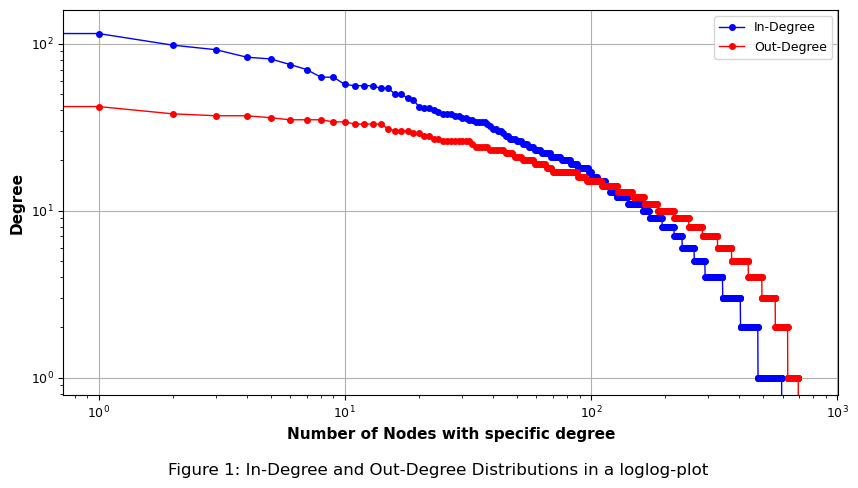

In [6]:
# plot the In-Degree and Out-Degree Distributions
plt.figure()
plt.loglog(in_degree_values, 'b-', marker='o', label='In-Degree')
plt.loglog(out_degree_values, 'r-', marker='o', label='Out-Degree')
plt.xlabel('Number of Nodes with specific degree')
plt.ylabel('Degree')
plt.legend()
plt.figtext(0.5, -0.05, f"Figure {figure_counter}: In-Degree and Out-Degree Distributions in a loglog-plot", wrap=True, horizontalalignment='center', fontsize=12)
figure_counter +=1
plt.show()


**Description of the plot**

The plots shows the in-degree and out-degree distributions. The in-degree and out-degree distributions follow a power-law distribution, which is common for many real-world networks. There is a small number of nodes (rappers) with high degrees, while most nodes have relatively low degrees.
Comparing the in and outgoing degrees, we can state that the number of incoming links is usually higher than the outgoing links. This could be explained by the lets call it 'rolemodel'-links. An less known rapper is stating that he got influenced by a very famous rapper and creates an incoming link for the famous rapper. Even though the famous rapper has maybe never heard about the less known rapper and therefore also no connection the less known rapper.
This could be also used to influence searching algorithms, because some one is trying to use as many as possible links to famous rapper to be more visible in in search engines.

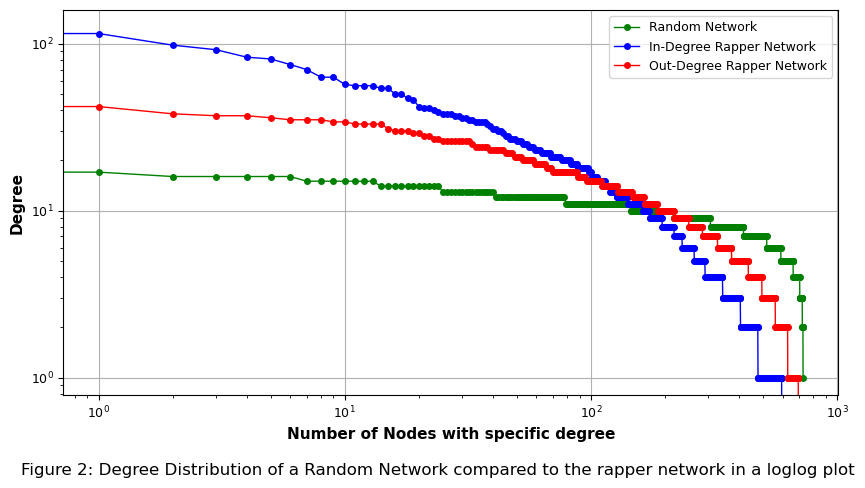

In [7]:
#plot the Degree Distribution of a Random Network like above
plt.figure()
plt.loglog(random_degrees, 'g-', marker='o', label='Random Network')
plt.loglog(in_degree_values, 'b-', marker='o', label='In-Degree Rapper Network')
plt.loglog(out_degree_values, 'r-', marker='o', label='Out-Degree Rapper Network')
plt.xlabel('Number of Nodes with specific degree')
plt.ylabel('Degree')
plt.legend()
plt.figtext(0.5, -0.05, f"Figure {figure_counter}: Degree Distribution of a Random Network compared to the rapper network in a loglog plot", wrap=True, horizontalalignment='center', fontsize=12)
figure_counter +=1
plt.show()


**Compare the two degree distributions to the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.**
  * The random network shows a more even distribution, suggesting that most nodes have a similar number of connections. This is in contrast to the observed power-law distributions for the in- and out-degrees in the rap network. The rap network has a few highly connected nodes, whereas in a random network, connections are more uniformly distributed. This showcases the uniqueness of real-world networks compared to theoretical random networks.

## Exercise 1b_: Visualization (see lecture 5 for more hints)

**Create a nice visualization of the total (directed) network:**
  * Color nodes according to the role;
  * Scale node-size according to degree;
  * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
  * Whatever else you feel like that would make the visualization nicer.
  * Describe the structure you observe. What useful information can you decipher from this?

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:42<00:00, 118.85it/s]
C:\Users\janle\AppData\Local\Temp\ipykernel_32708\2579433904.py:53: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, positions, alpha=0.05, edge_color = edge_color_list)


BarnesHut Approximation  took  6.78  seconds
Repulsion forces  took  33.30  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.93  seconds


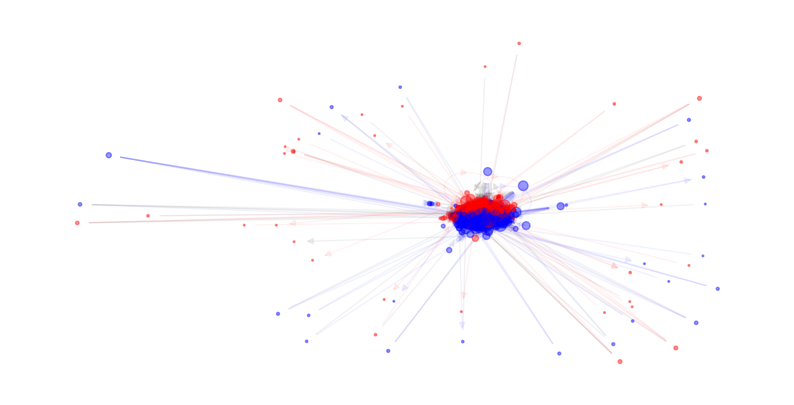

In [16]:
#node color
node_colors = []


for key, value in nx.get_node_attributes(G, 'coast').items():
    if value == 'east':
        node_colors.append('blue')
    elif value == 'west':
        node_colors.append('red')
    else:
        node_colors.append('gray')


# node size 
node_sizes = [G.degree(node) * 1.5 for node in G.nodes()]

#color of the edge is based on the coast of the source node
edge_color_list = []
for edge in G.edges():
    if G.nodes[edge[0]]["coast"] == "west" and G.nodes[edge[1]]["coast"] == "west":
        edge_color_list.append("red")
    elif G.nodes[edge[0]]["coast"] == "east" and G.nodes[edge[1]]["coast"] == "east":
        edge_color_list.append("blue")
    else:
        edge_color_list.append("black")

#position
# create a ForceAtlas2 object
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=0.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=10.0,
                        strongGravityMode=False,
                        gravity=0.15,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5000)

nx.draw_networkx_nodes(G, positions, node_size=node_sizes, node_color=node_colors, alpha=0.4)
nx.draw_networkx_edges(G, positions, alpha=0.05, edge_color = edge_color_list)
plt.axis('off')
plt.show() 

**Describe the plot and adjust it maybe ???**


# Part 2: Word-clouds

## Data processing

**cleaning of the corpus**
- Remove all punctuation from your list of tokens

- Set everything to lower case

- Lemmatize your words

In [22]:
from nltk.corpus import PlaintextCorpusReader
from nltk import Text

cwd = os.getcwd()
print(cwd)

corpus_root_east = cwd +'/eastcoasttexts'

corpus_root_west = cwd +'/westcoasttexts'

#create new corpus only west coast

# delete all empty files in the dictonary
import os
for filename in os.listdir(corpus_root_west):
    if os.path.getsize(corpus_root_west + '/' + filename) == 0:
        os.remove(corpus_root_west + '/' + filename)

for filename in os.listdir(corpus_root_east):
    if os.path.getsize(corpus_root_east + '/' + filename) == 0:
        os.remove(corpus_root_east + '/' + filename)

rapper_corpus_west = PlaintextCorpusReader(corpus_root_west, '.*\.txt')
rapper_text_west = Text(rapper_corpus_west.words())

rapper_corpus_east = PlaintextCorpusReader(corpus_root_east, '.*\.txt')
rapper_text_east = Text(rapper_corpus_east.words())

rapper_tokens_west = rapper_text_west.tokens
rapper_tokens_east = rapper_text_east.tokens

#print the size in bites of the corpus
import os
total_size_west = 0
total_size_east = 0
for filename in os.listdir(corpus_root_west):
    total_size_west += os.path.getsize(corpus_root_west + '/' + filename)
for filename in os.listdir(corpus_root_east):
    total_size_east += os.path.getsize(corpus_root_east + '/' + filename)

print('The size of the west coast corpus is: ' + str(total_size_west) + ' bytes')
print('The size of the east coast corpus is: ' + str(total_size_east) + ' bytes')

# Remove all punctuation from your list of tokens
import string
punctuation = string.punctuation
rapper_tokens_west = [word for word in rapper_tokens_west if word not in punctuation]
rapper_tokens_east = [word for word in rapper_tokens_east if word not in punctuation]

# Set everything to lower case
rapper_tokens_west = [word.lower() for word in rapper_tokens_west]
rapper_tokens_east = [word.lower() for word in rapper_tokens_east]

# Lemmatize your words
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
rapper_tokens_west = [wnl.lemmatize(word) for word in rapper_tokens_west]
rapper_tokens_east = [wnl.lemmatize(word) for word in rapper_tokens_east]

import csv
with open('rapper_tokens_west.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(rapper_tokens_west)

with open('rapper_tokens_east.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(rapper_tokens_east)

c:\Users\janle\Desktop\Master\1\SocialGraphs_assignments
The size of the west coast corpus is: 2138307 bytes
The size of the east coast corpus is: 3494039 bytes


In [23]:
rapper_tokens_west = pd.read_csv('rapper_tokens_west.csv', header=None).iloc[0].tolist()
rapper_tokens_east = pd.read_csv('rapper_tokens_east.csv', header=None).iloc[0].tolist()


Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from rappers' Wikipedia pages.

Here's what you need to do:
* Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.
* For each coast, what are the 5 words with the highest TR scores? Comment on your result.

In [24]:
# count the frequency of each token in the text 

fdist_west = FreqDist(rapper_tokens_west)
fdist_east = FreqDist(rapper_tokens_east)

# make dict out of frequency distribution
freq_west = dict(fdist_west)
freq_east = dict(fdist_east)


In [25]:
# calculate a score for each word in east. The formular is (Tf_w)/(Tf_e + c)
# Tf_w = term frequency in west
# Tf_e = term frequency in east

# create dict with score for each word
score_dict_east = {}
c = 5
for word in freq_east:
    if word in freq_west:
        score_dict_east[word] = freq_east[word]/(freq_west[word]+c)
    else:
        score_dict_east[word] = freq_east[word]/c


# create dict with score for each word
score_dict_west = {}
c = 5
for word in freq_west:
    if word in freq_east:
        score_dict_west[word] = freq_west[word]/(freq_east[word]+c)
    else:
        score_dict_west[word] = freq_west[word]/c



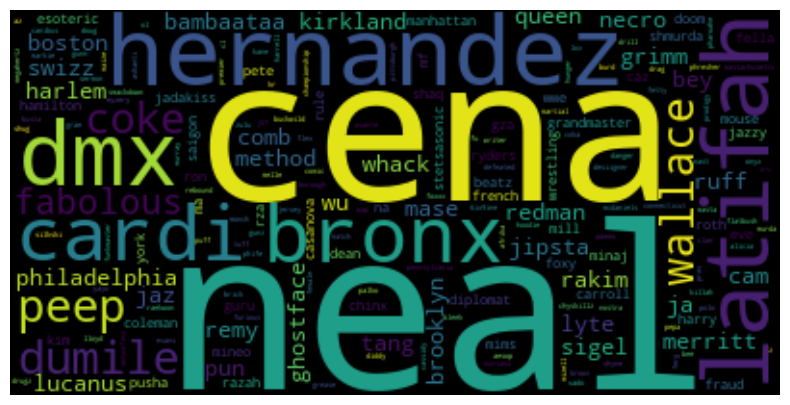

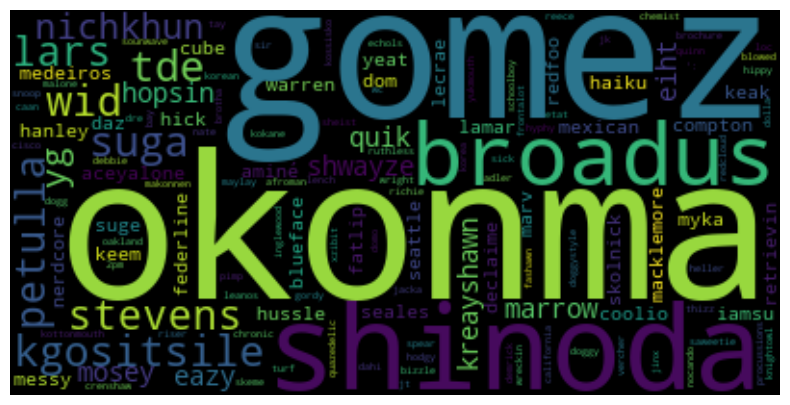

In [28]:
# create wordcloud
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(score_dict_east)
wordcloud.to_image()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# create wordcloud
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(score_dict_west)
wordcloud.to_image()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [30]:
# sort dict by value

sorted_score_dict_east = sorted(score_dict_east.items(), key=operator.itemgetter(1), reverse=True)
sorted_score_dict_west = sorted(score_dict_west.items(), key=operator.itemgetter(1), reverse=True)

#print top 10 words
print(sorted_score_dict_east[:5])
print(sorted_score_dict_west[:5])

[('neal', 34.583333333333336), ('cena', 27.25), ('hernandez', 26.166666666666668), ('latifah', 23.5), ('dmx', 22.09090909090909)]
[('okonma', 21.2), ('gomez', 20.25), ('shinoda', 17.0), ('broadus', 16.8), ('kgositsile', 14.0)]


**Comment on the finding**

# Part 3: Communities

Find communities and their modularity (from lecture 7).

Here's what you need to do:
> * In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it. 
> * Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?
> * Comment on your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.
> * Now, partition your rappers into two communities based on which coast they represent.
>   * What is the modularity of this partition? Comment on the result.

# Part 4: Sentiment of communities

Analyze the sentiment of communities (lecture 8). More tips & tricks can be found, if you take a look at Lecture 8's exercises.


In [ ]:
labmt=pd.read_csv('Data_Set_S1.txt', delimiter='\t')

In [ ]:
def sentiment(labmt,tokens):

    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]
    
    freq_dist = FreqDist(tokens)
    
    # Calculate sentiment scores for unique words
    sentiment_scores = {}

    for word, frequency in freq_dist.items():
        matching_word = labmt[labmt['Word'] == word]
        if not matching_word.empty:
            sentiment = matching_word['Happiness_Average'].values[0]
            sentiment_scores[word] = sentiment

    # Calculate weighted mean sentiment
    total_sentiment = sum(sentiment_scores[word] * freq for word, freq in freq_dist.items())
    total_frequency = sum(freq_dist.values())
    weighted_mean_sentiment = total_sentiment / total_frequency
    
    # Calculate the average sentiment score
    if word_count > 0:
        average_sentiment = sentiment_sum / word_count
    else:
        average_sentiment = 0  # If no LabMT words found, return a neutral sentiment
    
    return average_sentiment

A couple of additional instructions you will need below:
* Average the average sentiment of the nodes in each community to find a community-level sentiment.

Here's what you need to do (use the LabMT wordlist approach):
> * Calculate and store sentiment for every rapper
> * Create a histogram of all rappers' associated sentiments.
> * What are the 10 rappers with happiest and saddest pages?

Now, compute the sentiment of each coast: 
> * Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).
> * Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.
> * Does the result make sense to you? Elaborate.

**Congratulations for making it to the end of the Assignment. Good luck with your independent project**

# References

[1] Python Regular Expressions. Accessed: Oct. 25, 2023. [Online]. Available: https://developers.google.com/edu/python/regular-expressions

                
                
[ex] Network Science by Albert-László Barabási - Chapter 3: equation (3.3). Accessed: Sep. 25, 2023. [Online]. Available: http://networksciencebook.com/  